# Prioritised screening assignments
This notebook is used to create assignments in the **OECD instruments** project on NACSOS-nexus   
Project ID: `8d36c360-3775-4d43-8f30-9fcd6151fe30`

Requirements:
```
pip install -U "nacsos_data[utils,scripts] @ git+ssh://git@gitlab.pik-potsdam.de/mcc-apsis/nacsos/nacsos-data.git@v0.19.0"
pip install -U pandas, torch, evaluate, tqdm, datasets, transformers, matplotlib
```

First, this notebook should be copied and the counter in the filename increased by 1. The notebook is kept in the repository as a log for each assignment scope.

You need to make changes in four places:
* Adjust the assignment scopes and resolutions where labels come from
* Adjust the filename where predictions are saved directly after training/predicting
* Adjust the filename where predictions were saved before running assignments
* Adjust the name, description, and configuration for the new assignment scope
* Adjust the filename where predictions and assignments are saved at the end

In [1]:
import logging
import uuid

import pandas as pd
import numpy as np
from sqlalchemy import select, func, distinct, or_, and_, union, text

from nacsos_data.db import get_engine
from nacsos_data.db.schemas.imports import Import, m2m_import_item_table
from nacsos_data.db.schemas.items.academic import AcademicItem, AcademicItemVariant
from nacsos_data.db.schemas.items.base import Item
from nacsos_data.db.schemas import AnnotationScheme, AssignmentScope, Assignment, Annotation, BotAnnotationMetaData, BotAnnotation
from nacsos_data.util.academic.duplicate import str_to_title_slug

db_engine = get_engine(conf_file='/usr/share/nacsos/server.env')

logging.basicConfig(format='%(asctime)s [%(levelname)s] %(name)s: %(message)s', level=logging.INFO)
logger = logging.getLogger('import')
logger.setLevel(logging.DEBUG)

pd.options.display.max_columns = None

PROJECT_ID = '8d36c360-3775-4d43-8f30-9fcd6151fe30'
SCHEME_ID = 'b6239498-aca3-4a5c-a8c0-879068378cb8'

IMPORT_ALL = '3833189f-28d4-441e-8276-53ddd399a8ed'
IMPORT_REL = '9a0c57a2-326c-4309-a8aa-58630071c79b'
IMPORTS = {
    IMPORT_ALL: 'Import (all)',
    IMPORT_REL: 'Classified relevant'
}

USERS = {
    'diana.danilenko': '37b6ce42-6008-4d5a-a307-797098a8f7d2',
    'tarun.khanna': '2f5f9cf5-7970-4576-9330-aee4d98030f0',
    'sarah.hoang': '46f155d0-4354-4b78-a096-53d6bc1e81f4',
    'klaas.miersch': 'ca4ad15d-cd34-4f06-9c86-c7422979011e',
    'andres.mena': '34536463-6250-43f4-8318-2595c273fa7e',
    'max.callaghan': 'b4c20ee5-e415-4ac8-8e9d-77770311e38c',
    'aditaya.rai': 'd4e62261-af93-4862-b61e-61c1d23f49e5',
    'devki.natu': 'a81b7a24-e581-4306-b8f9-36b5118c492c',
    'jonas.weisser': 'c86564e7-5034-4f7c-abff-657bb60cb46d',
}
USERS_MAP = {v: k for k, v in USERS.items()}

## Data helpers
Some of the cells later on require you to specify the imports, annotation scheme, assignment scopes, or resolutions to use as labelled data. The following three cells are helpers to generate these lists.

In [ ]:
with db_engine.session() as session:
    rslt = session.execute(select(AssignmentScope).join(AnnotationScheme).where(AnnotationScheme.project_id == PROJECT_ID).order_by(AssignmentScope.name)).scalars().all()
    for r in rslt:
        print(f"'{r.assignment_scope_id}',  # {r.name}")
    print()
    rslt = session.execute(select(BotAnnotationMetaData).where(BotAnnotationMetaData.project_id == PROJECT_ID).order_by(BotAnnotationMetaData.name)).scalars().all()
    for r in rslt:
        print(f"'{r.bot_annotation_metadata_id}',  # {r.name}")
    print()
    rslt = session.execute(select(Import).where(Import.project_id == PROJECT_ID).order_by(Import.name)).scalars().all()
    for r in rslt:
        print(f"'{r.import_id}': '{r.name}',")

In [5]:
# Where to get the labels from IN ORDER OF PRIORITISATION!
SCOPES = [
    'e0660ab5-8d47-4dd3-a28a-7c8fb487f72b',  # [RES] Tarun-Sarah
    '354fd78f-14be-4042-b744-ee2b31c1f4b4',  # [RES] Sarah
    '91b2a57d-2713-4cc8-9339-f8bb5b88a1f3',  # [RES] Klaas-Sarah
    'f5b9a0f7-77ff-48dc-ab2b-659aca30ba14',  # randomsample_relimport
    '7e9b2d50-8ae6-47b2-89bb-74f02c819e3e',  # 20240812_prioritised_independent
    '44aae15f-3967-4e60-9533-72d02af1f04a',  # 20240819_prioritised_independent
    '69d1b7e1-ce96-4179-a4cd-fd0a4fdacc10',  # 20240821_prioritised_SH_TK_KM
    '8fff179f-4a2d-4ab3-a63e-da97287113d7',  # 20240827_prioritised_SH_TK
    '7041e5cc-7a0a-428c-896f-2610272063cd', # [RES] Resolved_20240904_random_KM_DN_JW_SH
    '6ba2ea64-14ef-4d01-b841-fa8a25e18494',  # 010_20240905_01_prioritised_SH_DN_JW
    '982f8740-48de-4a7d-88ef-c1da32ccb373',  # [RES] Resolved_20240905_02_prioritised_SH_DN_JW
    'e343e57c-dccd-4c7f-91ce-17599bb6bd84',  # [RES] Resolved_20240905_03_prioritised_SH_DN_JW
    '20ffd9ac-e821-4de4-b80f-8d5f37da12e3',  # [RES] Resolved_013_17092024_prioritized_25_KM_DN
    '7951a919-27ce-4c38-a5c1-53b69372f693',  # 014_17092024_prioritised_independent
    '53d32d96-af4b-40c9-b2a2-2513b725037d',  # [RES] Resolved_20240924_prioritized_200_DN_JW
    '2ed73bd7-bb37-43bc-a03d-1475eec736e7',  # [RES] Resolved_20240924_prioritized_200_JW_SH
    '519a5777-6cd6-4237-b364-f6b811569af7',  # [RES] Resolved_20240924_prioritized_50_JW_SH_DN
    '5fa719c4-0340-4140-b008-f8e87b33fd70',  # [RES] Resolved_018_20240924_prioritized_200_DN_SH
    '675dca41-0e1a-41ff-a2ee-7fa0a1ad4ba4',  # 019_20240924_prioritized_350_SH
    '2c5a16f6-ab9a-4228-ab7f-8d6b188d99a5',  # [RES] Resolved_020_20241010_01_prioritised_300_SH_DN
    '247b4310-0131-4265-87e6-c459507b0af0',  # [RES] Resolved_021_20241010_02_prioritised_300_DN_JW
    '6fe91cb5-6ec3-4ad5-9e2b-39d7e757319b',  # 022_20241029_01_prioritized_400_SH_DN
    'dd5d100f-04c4-4420-b4c2-b96196ba53c9',  # 023_20241029_02_prioritized_400_SH_JW
    '19d96eae-9e59-4306-9d6f-3bedea1cc026',  # [RES] Resolved_024_20241029_03_prioritized_400_DN_JW
]

## Data preparation
The following cells fetch all the data from the database.

You may need to adjust the list of assignment scopes (in `ass.assignment_scope_id::text = ANY (array [...])`) for all labels that were not resolved yet (using "majority vote" of double-codings). Also, you may need to adjust the list of resolved labels (in `a.bot_annotation_metadata_id::text = ANY (array [...])`).    
Scopes that were resolved should not appear in the list of `assignment_scope_id`s, but only in the list of `bot_annotation_metadata_id`s!

This query usually takes ~20-60s to finish.

In [6]:
stmt = text('''
WITH
    scopes as (
        SELECT scope_id::uuid,
               row_number() OVER () AS scope_order
        FROM unnest(:scopes ::uuid[]) as scope_id),
    labels_flat as (
        SELECT ba.item_id,
               ba."order",
               scope.scope_order,
               json_object_agg(ba.key,
                               json_build_object('bool', ba.value_bool,
                                                 'int', ba.value_int,
                                                 'multi', ba.multi_int)) as label
        FROM bot_annotation ba
             JOIN scopes scope ON scope.scope_id = ba.bot_annotation_metadata_id
        GROUP BY ba.item_id, ba."order", scope.scope_order),
    labels as (
        SELECT item_id,
               min(scope_order) as scope_order,
               min("order")     as item_order,
               json_agg(label)  as labels
        FROM labels_flat
        GROUP BY item_id),
    ulabels_flat as (
        SELECT ass.item_id,
               ass."order",
               scope.scope_order,
               u.username,
               json_object_agg(a.key,
                               json_build_object('bool', a.value_bool,
                                                 'int', a.value_int,
                                                 'multi', a.multi_int)) as label
        FROM annotation a
             JOIN "user" u ON u.user_id = a.user_id
             JOIN assignment ass ON a.item_id = ass.item_id
             JOIN scopes scope ON scope.scope_id = ass.assignment_scope_id
        GROUP BY ass.item_id, ass."order", scope.scope_order, u.username),
    ulabels as (
        SELECT item_id,
               min(scope_order)                 as scope_order,
               min("order")                     as item_order,
               json_object_agg(username, label) as labels
        FROM ulabels_flat
        GROUP BY item_id),
    imports as (
        SELECT item_id,
               array_agg(DISTINCT import_id) as imports
        FROM m2m_import_item mii
        GROUP BY item_id)
SELECT i.item_id,
       i.text                                            as abstract,
       ai.title,
       ai.publication_year                               as py,
       ai.wos_id,
       ai.doi,
       labels.labels                                     as labels_resolved,
       ulabels.labels                                    as labels_unresolved,
       imports.imports,
       coalesce(labels.scope_order, ulabels.scope_order) as scope_order,
       coalesce(labels.item_order, ulabels.item_order)   as item_order
FROM item i
     JOIN academic_item ai on i.item_id = ai.item_id
     LEFT OUTER JOIN labels ON i.item_id = labels.item_id
     LEFT OUTER JOIN ulabels ON i.item_id = ulabels.item_id
     LEFT OUTER JOIN imports ON i.item_id = imports.item_id
WHERE i.project_id = :project_id
ORDER BY scope_order, item_order;
''')

with db_engine.session() as session:
    rslt = session.execute(stmt, {'scopes': SCOPES, 'project_id': PROJECT_ID}).mappings().all()
    assigned_item_ids = session.execute(
                        select(distinct(Assignment.item_id))
                           .join(Item)
                           .where(Item.project_id == PROJECT_ID)).scalars().all()
    assigned_item_ids = [str(r) for r in assigned_item_ids]

We'd like to transform the data we retrieved from the database a little more and construct a dataframe in the following cell.

In [7]:
SECTORS = [{'name': 'AFOLU', 'hint': '', 'value': 1, 'children': None}, 
           {'name': 'Buildings', 'hint': None, 'value': 2, 'children': None}, 
           {'name': 'Industry', 'hint': None, 'value': 3, 'children': None},
           {'name': 'Energy', 'hint': None, 'value': 4, 'children': None}, 
           {'name': 'Transport', 'hint': None, 'value': 5, 'children': None}, 
           {'name': 'Waste', 'hint': None, 'value': 6, 'children': None}, 
           {'name': 'Cross-sectoral', 'hint': None, 'value': 15, 'children': None}]

def unpack_multi(prefix, labels):
    return {
        f'{prefix}|{key}|{val}': True
        for li in (labels or [])
        for key, values in li.items()
        if values['multi'] is not None
        for val in values['multi']
    }
def unpack_bool(prefix, labels):
    return {
        f'res|{key}': values['bool']
        for li in (labels or [])
        for key, values in li.items()
        if values['bool'] is not None
    }
def unpack_int(prefix, labels):
    return {
        f'res|{key}|{values["int"]}': True
        for li in (labels or [])
        for key, values in li.items()
        if values['int'] is not None
    }

# Transform all results to flat dicts
data = [{
        'scope_order': r['scope_order'],
        'item_order': r['item_order'],
        'item_id': str(r['item_id']),
        'title': r['title'],
        'abstract': r['abstract'],
        'text': f"{r['title']} {r['abstract']}",
        'wos_id': r['wos_id'],
        'doi': r['doi'],
        'py': r['py'],
        'labels_resolved': r['labels_resolved'],
        'labels_unresolved': r['labels_unresolved'],
        'imports': [str(ri) for ri in r['imports']],
        **{
            IMPORTS[str(im)]: True
            for im in r['imports']
            if str(im) in IMPORTS
        },

        # Resolved labels
        **unpack_bool('res', r['labels_resolved']),
        **unpack_multi('res', r['labels_resolved']),
    
        # Unresolved labels
        **{k: v for user, labels in (r['labels_unresolved'] or {}).items() for k, v in unpack_bool(user, [labels]).items()},
        **{k: v for user, labels in (r['labels_unresolved'] or {}).items() for k, v in unpack_multi(user, [labels]).items()},

        # Fake-resolved labels
        **{k: v for user, labels in (r['labels_unresolved'] or {}).items() for k, v in unpack_bool('ures', [labels]).items()},
        **{k: v for user, labels in (r['labels_unresolved'] or {}).items() for k, v in unpack_multi('ures', [labels]).items()}
    } for r in rslt]

# Fix all potential columns
keys_base = ['scope_order', 'item_order', 'item_id', 'title', 'abstract', 'text', 'wos_id', 'doi', 'py']
keys_meta =  ['labels_resolved', 'labels_unresolved', 'imports']
keys_imports = list(IMPORTS.values())
keys_users_incl = [f'{user}|inclusion' for user in USERS.keys()]
keys_users_sect = [f'{user}|sector|{s["value"]}' for s in SECTORS for user in USERS.keys()]
keys_user_incl = ['ures|inclusion']
keys_user_sect =  [f'ures|sector|{s["value"]}' for s in SECTORS]
keys_res_incl = ['res|inclusion']
keys_res_sect = [f'res|sector|{s["value"]}' for s in SECTORS]
keys_coal_incl = ['inclusion']
keys_coal_sect = [f'sector|{s["value"]}' for s in SECTORS]

columns = (
    keys_base
    + keys_meta
    + keys_imports
    + keys_users_incl
    + keys_users_sect
    + keys_user_incl
    + keys_user_sect
    + keys_res_incl
    + keys_res_sect
)

# Construct dataframe
df = pd.DataFrame(data, columns=columns)
df['scope_order'] = df['scope_order'].astype('Int64').astype('Int8')
df['item_order'] = df['item_order'].astype('Int64').astype('Int8')
df['py'] = df['py'].astype('Int16')

# Coalescing data (pick either resolved or unresolved)
df['inclusion'] = df['res|inclusion'].combine_first(df['ures|inclusion']).astype('Int8')
for key in keys_coal_incl + keys_coal_sect:
    df[key] = df[f'res|{key}'].combine_first(df[f'ures|{key}']).astype('Int8')

# Add more columns
df.loc[df['item_id'].isin(assigned_item_ids), 'assigned'] = True
df.loc[df['labels_resolved'].notnull() | df['labels_unresolved'].notnull(), 'seen'] = True
df.loc[df['labels_resolved'].notnull(), 'resolved'] = True
# Hacky way of filling nulls with False
df['assigned'] = df['assigned'] == True
df['resolved'] = df['resolved'] == True
df['seen'] = df['seen'] == True

# replace of NaNs with None
df = df.replace({np.nan: None})

def oring(arr):
    ret = arr[0]
    for a in arr[1:]:
        ret |= a
    return ret

def anding(arr):
    ret = arr[0]
    for a in arr[1:]:
        ret &= a
    return ret

mask_seen = df['seen'] == True
mask_unseen = ~mask_seen

print(df.columns)

print('Shape:', df.shape)
print(f'Seen: {mask_seen.sum():,} | unseen: {mask_unseen.sum():,}')
df.head()

Index(['scope_order', 'item_order', 'item_id', 'title', 'abstract', 'text',
       'wos_id', 'doi', 'py', 'labels_resolved',
       ...
       'sector|1', 'sector|2', 'sector|3', 'sector|4', 'sector|5', 'sector|6',
       'sector|15', 'assigned', 'seen', 'resolved'],
      dtype='object', length=113)
Shape: (74867, 113)
Seen: 5,613 | unseen: 69,254


scope_order item_order                               item_id  \
0           1          1  9a878b97-de97-42d0-8be6-a18fad2bb952   
1           1          2  02e2e1b0-5236-4bf9-83f8-4e35cbcea6b0   
2           1          3  58d7ab47-21c8-4195-981b-ef88f13b4af5   
3           1          4  1a96175c-c74e-4b16-b911-638e7f954abf   
4           1          5  88fbda2c-3128-47b0-ba2c-50135208afe8   

                                               title  \
0  Incorporating Costs of Life-Cycle Impacts into...   
1  From risk to return: investing in climate chan...   
2  Análisis de las capacidades del Ejército Nacio...   
3  Methanol synthesis from flue-gas CO2 and renew...   
4  Implementation of the Energy Efficiency Existi...   

                                            abstract  \
0  Ensuring sustainability is necessary for balan...   
1  [Extract] Executive Summary. \r\nToo often, cl...   
2  In this essay has as a goal to analysis of cap...   
3  Abstract The twin requirements of reducing CO2...   
4  For decades, the shipping sector has been inco...   

                                                text wos_id  \
0  Incorporating Costs of Life-Cycle Impacts into...   None   
1  From risk to return: investing in climate chan...   None   
2  Análisis de las capacidades del Ejército Nacio...   None   
3  Methanol synthesis from flue-gas CO2 and renew...   None   
4  Implementation of the Energy Efficiency Existi...   None   

                             doi    py  \
0                10.3141/2453-10  2014   
1                           None  2017   
2                           None  2019   
3  10.1016/s0360-3199(02)00082-4  2003   
4   10.1016/j.marpol.2022.105259  2022   

                                     labels_resolved  \
0  [{'inclusion': {'bool': False, 'int': None, 'm...   
1  [{'inclusion': {'bool': False, 'int': None, 'm...   
2  [{'sector': {'bool': None, 'int': None, 'multi...   
3  [{'inclusion': {'bool': False, 'int': None, 'm...   
4  [{'inclusion': {'bool': False, 'int': None, 'm...   

                                   labels_unresolved  \
0                                               None   
1                                               None   
2                                               None   
3                                               None   
4  {'tarun.khanna': {'inclusion': {'bool': False,...   

                                             imports  Import (all)  \
0             [3833189f-28d4-441e-8276-53ddd399a8ed]          True   
1             [3833189f-28d4-441e-8276-53ddd399a8ed]          True   
2             [3833189f-28d4-441e-8276-53ddd399a8ed]          True   
3             [3833189f-28d4-441e-8276-53ddd399a8ed]          True   
4  [3833189f-28d4-441e-8276-53ddd399a8ed, 9a0c57a...          True   

  Classified relevant diana.danilenko|inclusion tarun.khanna|inclusion  \
0                None                      None                   None   
1                None                      None                   None   
2                None                      None                   None   
3                None                      None                   None   
4                True                      None                   None   

  sarah.hoang|inclusion klaas.miersch|inclusion andres.mena|inclusion  \
0                  None                    None                  None   
1                  None                    None                  None   
2                  None                    None                  None   
3                  None                    None                  None   
4                  None                    None                  None   

  max.callaghan|inclusion aditaya.rai|inclusion devki.natu|inclusion  \
0                    None                  None                 None   
1                    None                  None                 None   
2                    None                  None                 None   
3                    None       

Check the number of inclusion/exclusion labels:

In [8]:
print(f'Number assigned: {df["assigned"].sum():,}')
print(f'Number annotated: {df["seen"].sum():,}')
print(f'Number annotated (but not resolved): {(df["seen"] & ~df["resolved"]).sum():,}')
print(f'Number resolved: {df["resolved"].sum():,}')

Number assigned: 5,813
Number annotated: 5,613
Number annotated (but not resolved): 3,514
Number resolved: 2,099


In [9]:
df['inclusion'].value_counts()

inclusion
0    4484
1    1129
Name: count, dtype: int64

In [10]:
for sec in SECTORS:
    cnt = df[f'sector|{sec["value"]}'].sum()
    print(f'{sec["name"]}: {cnt:,}')

AFOLU: 901
Buildings: 351
Industry: 219
Energy: 685
Transport: 419
Waste: 25
Cross-sectoral: 544


Text(0, 0.5, 'Number of included documents')

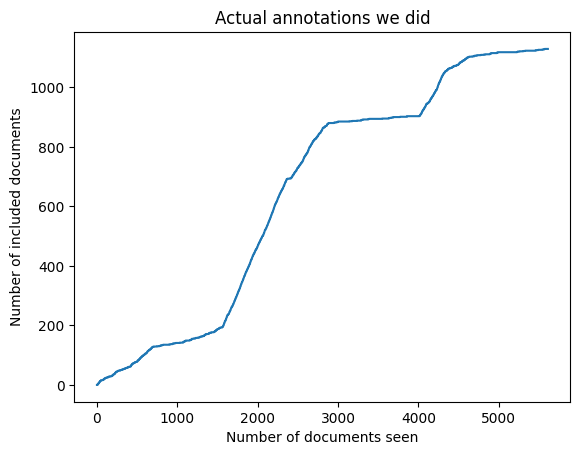

In [11]:
from matplotlib import pyplot as plt

plt.title('Actual annotations we did')
plt.plot(df.sort_values(['scope_order', 'item_order'], ascending=True)['inclusion'].cumsum(skipna=True).reset_index(drop=True))
plt.xlabel('Number of documents seen')
plt.ylabel('Number of included documents')

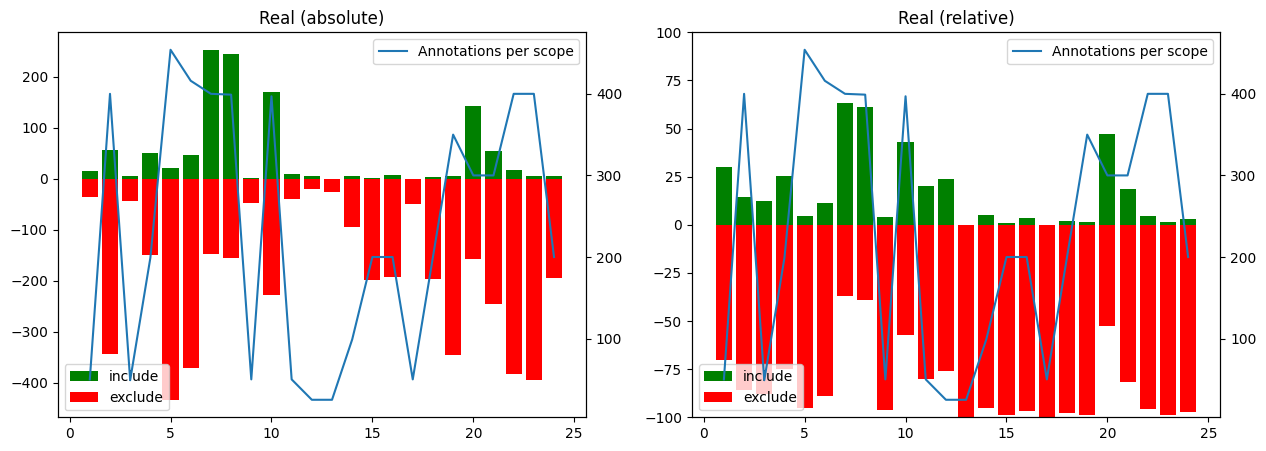

In [12]:
fix, axes = plt.subplots(1, 2, figsize=(15,5))

rtotal = df[mask_seen].groupby('scope_order')['item_id'].count()
rincl = df[mask_seen].groupby('scope_order')['inclusion'].sum()

ax = axes[0]
ax.set_title('Real (absolute)')
ax.bar(rincl.index, rincl, label='include', color='green')
ax.bar(rincl.index, (rincl - rtotal), label='exclude', color='red')
ax.legend(loc='lower left')
ax = ax.twinx()
ax.plot(rtotal, label='Annotations per scope')
ax.legend()

ax = axes[1]
ax.set_title('Real (relative)')
ax.set_ylim(-100,100)
ax.bar(rincl.index, (rincl/rtotal)*100, label='include', color='green')
ax.bar(rincl.index, ((rincl-rtotal)/rtotal)*100, label='exclude', color='red')
ax.legend(loc='lower left')
ax = ax.twinx()
ax.plot(rtotal, label='Annotations per scope')
ax.legend()

In [13]:
from IPython.display import display_html 
print('Numbers used in plots')
print()
print('bottom left blue')
display_html(pd.DataFrame(rtotal).T)
print('bottom left green')
display_html(pd.DataFrame(rincl).T)
print('bottom left red')
display_html(pd.DataFrame((rincl-rtotal)).T)
print()
print('bottom right blue')
display_html(pd.DataFrame(rtotal).T)
print('bottom right green')
display_html(pd.DataFrame((rincl/rtotal)*100).T)
print('bottom right red')
display_html(pd.DataFrame(((rincl-rtotal)/rtotal)*100).T)

Numbers used in plots

bottom left blue


scope_order 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 10 
 11 
 12 
 13 
 14 
 15 
 16 
 17 
 18 
 19 
 20 
 21 
 22 
 23 
 24 
 
 
 
 
 item_id 
 50 
 400 
 49 
 199 
 454 
 416 
 400 
 399 
 50 
 397 
 50 
 25 
 25 
 99 
 200 
 200 
 50 
 200 
 350 
 300 
 300 
 400 
 400 
 200

bottom left green


scope_order 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 10 
 11 
 12 
 13 
 14 
 15 
 16 
 17 
 18 
 19 
 20 
 21 
 22 
 23 
 24 
 
 
 
 
 inclusion 
 15 
 57 
 6 
 50 
 21 
 46 
 253 
 244 
 2 
 170 
 10 
 6 
 0 
 5 
 2 
 7 
 0 
 4 
 5 
 142 
 55 
 18 
 5 
 6

bottom left red


scope_order 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 10 
 11 
 12 
 13 
 14 
 15 
 16 
 17 
 18 
 19 
 20 
 21 
 22 
 23 
 24 
 
 
 
 
 0 
 -35 
 -343 
 -43 
 -149 
 -433 
 -370 
 -147 
 -155 
 -48 
 -227 
 -40 
 -19 
 -25 
 -94 
 -198 
 -193 
 -50 
 -196 
 -345 
 -158 
 -245 
 -382 
 -395 
 -194


bottom right blue


scope_order 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 10 
 11 
 12 
 13 
 14 
 15 
 16 
 17 
 18 
 19 
 20 
 21 
 22 
 23 
 24 
 
 
 
 
 item_id 
 50 
 400 
 49 
 199 
 454 
 416 
 400 
 399 
 50 
 397 
 50 
 25 
 25 
 99 
 200 
 200 
 50 
 200 
 350 
 300 
 300 
 400 
 400 
 200

bottom right green


scope_order 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 10 
 11 
 12 
 13 
 14 
 15 
 16 
 17 
 18 
 19 
 20 
 21 
 22 
 23 
 24 
 
 
 
 
 0 
 30.0 
 14.25 
 12.244898 
 25.125628 
 4.625551 
 11.057692 
 63.25 
 61.152882 
 4.0 
 42.821159 
 20.0 
 24.0 
 0.0 
 5.050505 
 1.0 
 3.5 
 0.0 
 2.0 
 1.428571 
 47.333333 
 18.333333 
 4.5 
 1.25 
 3.0

bottom right red


scope_order 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 10 
 11 
 12 
 13 
 14 
 15 
 16 
 17 
 18 
 19 
 20 
 21 
 22 
 23 
 24 
 
 
 
 
 0 
 -70.0 
 -85.75 
 -87.755102 
 -74.874372 
 -95.374449 
 -88.942308 
 -36.75 
 -38.847118 
 -96.0 
 -57.178841 
 -80.0 
 -76.0 
 -100.0 
 -94.949495 
 -99.0 
 -96.5 
 -100.0 
 -98.0 
 -98.571429 
 -52.666667 
 -81.666667 
 -95.5 
 -98.75 
 -97.0

## Stopping criterion

BUSCAR Scores


0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 10 
 11 
 12 
 13 
 14 
 15 
 16 
 17 
 18 
 19 
 20 
 21 
 22 
 23 
 24 
 25 
 26 
 27 
 28 
 29 
 30 
 31 
 32 
 33 
 34 
 35 
 36 
 37 
 38 
 39 
 40 
 41 
 42 
 43 
 44 
 45 
 46 
 47 
 48 
 49 
 50 
 51 
 52 
 53 
 54 
 55 
 56 
 
 
 
 
 batch_sizes 
 100.000000 
 200.00000 
 300.000000 
 400.000000 
 500.000000 
 600.0 
 700.00000 
 800.000000 
 900.000000 
 1000.000000 
 1100.000000 
 1200.000000 
 1300.000000 
 1400.0 
 1500.000000 
 1600.000000 
 1700.000000 
 1800.000000 
 1900.0 
 2000.0 
 2100.000000 
 2200.0 
 2300.000000 
 2400.000000 
 2500.000000 
 2600.0 
 2700.000000 
 2800.0 
 2900.00000 
 3000.000000 
 3100.000000 
 3200.00000 
 3300.00000 
 3400.000000 
 3500.000000 
 3600.000000 
 3700.000000 
 3800.000000 
 3900.000000 
 4000.000000 
 4100.000000 
 4200.000000 
 4300.0 
 4400.000000 
 4500.00000 
 4600.000000 
 4700.00000 
 4800.000000 
 4900.000000 
 5000.000000 
 5100.000000 
 5200.000000 
 5300.000000 
 5400.000000 
 5500.000000 
 5600.000000 
 5613.000000 
 
 
 p 
 0.999973 
 0.99992 
 0.999678 
 0.999893 
 0.999597 
 1.0 
 0.99934 
 0.999676 
 0.999963 
 0.997836 
 0.999133 
 0.997925 
 0.998533 
 1.0 
 0.999455 
 0.999836 
 0.999795 
 0.999507 
 1.0 
 1.0 
 0.998462 
 1.0 
 0.998554 
 0.986812 
 0.998384 
 1.0 
 0.999996 
 1.0 
 0.99025 
 0.999346 
 0.937245 
 0.98632 
 0.99998 
 0.990639 
 0.926225 
 0.968188 
 0.994617 
 0.981926 
 0.974624 
 0.910819 
 0.999999 
 0.999264 
 1.0 
 0.998383 
 0.99919 
 0.999962 
 0.99748 
 0.981641 
 0.999996 
 0.994944 
 0.914287 
 0.840067 
 0.966085 
 0.941336 
 0.993961 
 0.976878 
 0.965934

Recall frontier (BUSCAR score per recall target)


0 
 1 
 2 
 3 
 4 
 5 
 6 
 7 
 8 
 9 
 10 
 11 
 12 
 13 
 14 
 15 
 16 
 17 
 18 
 19 
 20 
 21 
 22 
 23 
 24 
 25 
 26 
 27 
 28 
 29 
 30 
 31 
 32 
 33 
 34 
 35 
 36 
 37 
 38 
 39 
 40 
 41 
 42 
 43 
 44 
 45 
 46 
 47 
 48 
 49 
 50 
 51 
 52 
 53 
 54 
 55 
 56 
 57 
 58 
 59 
 60 
 61 
 62 
 63 
 64 
 65 
 66 
 67 
 68 
 69 
 70 
 71 
 72 
 73 
 74 
 75 
 76 
 77 
 78 
 79 
 80 
 81 
 82 
 83 
 84 
 85 
 86 
 87 
 88 
 89 
 90 
 91 
 92 
 93 
 94 
 95 
 96 
 97 
 98 
 99 
 100 
 101 
 102 
 103 
 104 
 105 
 106 
 107 
 108 
 109 
 110 
 111 
 112 
 113 
 114 
 115 
 116 
 117 
 118 
 119 
 120 
 121 
 122 
 123 
 124 
 125 
 126 
 127 
 128 
 129 
 130 
 131 
 132 
 133 
 134 
 
 
 
 
 recall_target 
 0.990000 
 0.985000 
 0.980000 
 0.975000 
 0.970000 
 0.965000 
 0.960000 
 0.955000 
 0.950000 
 0.94500 
 0.940000 
 0.935000 
 0.930000 
 0.925000 
 0.920000 
 0.91500 
 0.910000 
 0.90500 
 0.900000 
 0.89500 
 0.890000 
 0.88500 
 0.880000 
 0.875000 
 0.870000 
 0.865000 
 0.860000 
 0.855000 
 0.850000 
 0.84500 
 0.840000 
 0.835000 
 0.830000 
 0.825000 
 0.820000 
 0.815000 
 0.810000 
 0.805000 
 0.800000 
 0.795000 
 0.790000 
 0.785000 
 0.78000 
 0.77500 
 0.770000 
 0.765000 
 0.760000 
 0.755000 
 0.750000 
 0.745000 
 0.740000 
 0.735000 
 0.730000 
 0.725000 
 0.720000 
 0.715000 
 0.710000 
 0.705000 
 0.700000 
 0.695000 
 0.690000 
 0.685000 
 0.680000 
 0.675000 
 0.670000 
 0.665000 
 0.660000 
 0.655000 
 0.650000 
 0.645000 
 0.640000 
 0.635000 
 0.630000 
 0.625000 
 0.620000 
 0.615000 
 0.610000 
 0.60500 
 0.60000 
 0.595000 
 0.590000 
 0.585000 
 0.580000 
 0.575000 
 0.570000 
 0.565000 
 0.560000 
 0.555000 
 0.550000 
 0.545000 
 0.540000 
 0.535000 
 0.530000 
 0.525000 
 0.520000 
 0.51500 
 0.510000 
 0.505000 
 0.50000 
 0.495000 
 0.490000 
 0.485000 
 0.480000 
 0.475000 
 0.470000 
 0.465000 
 0.460000 
 0.455000 
 0.450000 
 0.445000 
 0.440000 
 0.435000 
 0.430000 
 0.425000 
 0.420000 
 0.415000 
 0.410000 
 0.405000 
 0.400000 
 0.395000 
 0.390000 
 0.385000 
 0.380000 
 0.375000 
 0.370000 
 0.365000 
 0.360000 
 0.355000 
 0.350000 
 0.345000 
 0.340000 
 0.335000 
 0.330000 
 0.325000 
 0.32000 
 
 
 p 
 0.993094 
 0.989659 
 0.986235 
 0.983391 
 0.979988 
 0.976597 
 0.972655 
 0.969289 
 0.965934 
 0.96259 
 0.958704 
 0.955384 
 0.952076 
 0.948231 
 0.944401 
 0.94113 
 0.937327 
 0.93354 
 0.929768 
 0.92601 
 0.922268 
 0.91854 
 0.914827 
 0.910601 
 0.906919 
 0.902729 
 0.899078 
 0.894923 
 0.890787 
 0.88667 
 0.882571 
 0.878491 
 0.874429 
 0.870385 
 0.866359 
 0.861853 
 0.857866 
 0.853402 
 0.848961 
 0.844542 
 0.840146 
 0.835772 
 0.83142 
 0.82709 
 0.822306 
 0.818022 
 0.813288 
 0.808581 
 0.803901 
 0.799247 
 0.794619 
 0.789559 
 0.784986 
 0.779985 
 0.775016 
 0.770077 
 0.765169 
 0.760292 
 0.755445 
 0.750191 
 0.744974 
 0.739791 
 0.734644 
 0.729532 
 0.724032 
 0.718992 
 0.713571 
 0.708189 
 0.702846 
 0.697137 
 0.691473 
 0.686254 
 0.680279 
 0.674749 
 0.669262 
 0.663432 
 0.657652 
 0.65154 
 0.64586 
 0.639855 
 0.633904 
 0.628008 
 0.621801 
 0.615655 
 0.609567 
 0.603186 
 0.596869 
 0.590617 
 0.584429 
 0.577966 
 0.571572 
 0.564917 
 0.558337 
 0.551832 
 0.545081 
 0.53841 
 0.531819 
 0.524999 
 0.51796 
 0.511313 
 0.504157 
 0.497391 
 0.490136 
 0.483269 
 0.475936 
 0.468987 
 0.461593 
 0.450315 
 0.423095 
 0.394639 
 0.368034 
 0.340572 
 0.314274 
 0.288392 
 0.263108 
 0.239314 
 0.216355 
 0.194372 
 0.173491 
 0.153817 
 0.135907 
 0.118827 
 0.103136 
 0.089185 
 0.076249 
 0.064679 
 0.054425 
 0.045423 
 0.037594 
 0.030716 
 0.024876 
 0.019876 
 0.015733 
 0.012337 
 0.00949

Score @ 4,800: 0.9816
Score @ 4,900: 1.0000
Score @ 5,000: 0.9949
Score @ 5,100: 0.9143
Score @ 5,200: 0.8401
Score @ 5,300: 0.9661
Score @ 5,400: 0.9413
Score @ 5,500: 0.9940
Score @ 5,600: 0.9769
Score @ 5,613: 0.9659


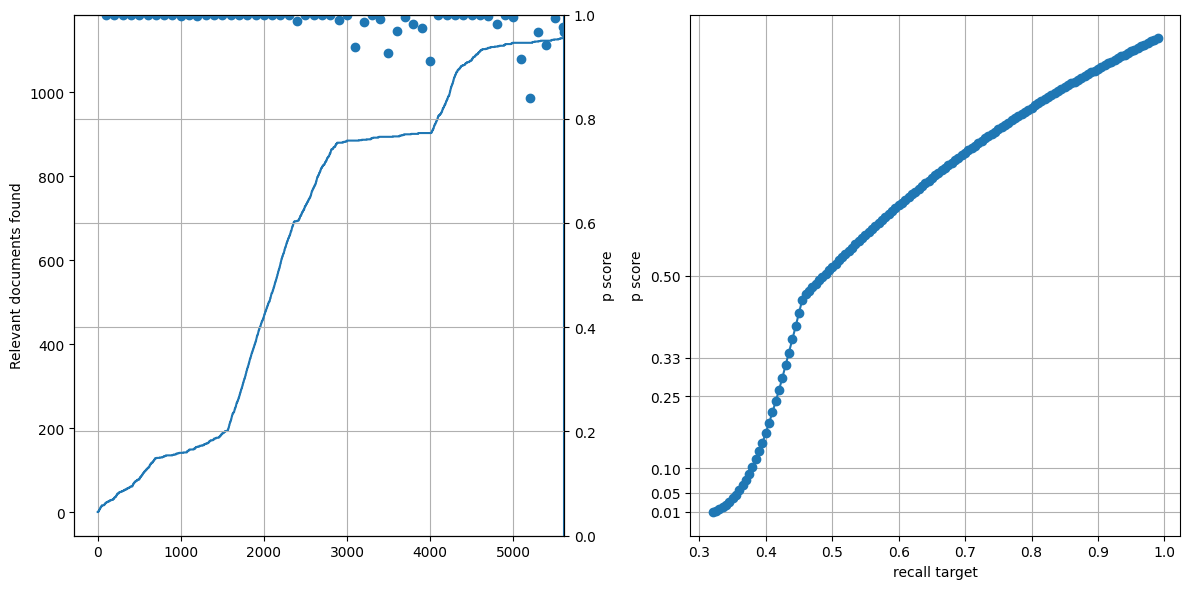

In [16]:
from buscarpy import retrospective_h0, recall_frontier
import matplotlib.pyplot as plt
       
# Initialise a figure with two panels
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

# Sort in order of prioritisation
srt_df = df.sort_values(['scope_order', 'item_order'], ascending=True).reset_index(drop=True)

# Derive meta-data
key = 'inclusion'
seen = ~srt_df[key].isna()  # mask of seen documents
n_seen = seen.sum()
n_incl = srt_df[key].sum()
n_total = srt_df.shape[0]

# Compute H0
buscar = retrospective_h0(srt_df[seen][key], n_total, batch_size=100, plot=False)
# Compute frontier
recall = recall_frontier(srt_df[key].dropna(), df.shape[0], plot=False)

print('BUSCAR Scores')
display_html(pd.DataFrame(buscar).T)
print('Recall frontier (BUSCAR score per recall target)')
display_html(pd.DataFrame(recall).T)

# Produce left panel
ax1.set_ylabel('Relevant documents found')
ax1.plot(srt_df[seen][key].cumsum())  # cumulative plot of included documents
ax1.axvline(n_seen)  # vertical line for where we are with screening
ax1.grid(axis='x')
ax1.set_xlim(xmax=n_seen)

ax1t = ax1.twinx()
ax1t.scatter(buscar['batch_sizes'], buscar['p'])
ax1t.set_ylim(ymax=1, ymin=0)
ax1t.set_ylabel('p score')
ax1t.grid()

ax2.plot(recall['recall_target'], recall['p'], marker='o')
ax2.set_ylabel('p score')
ax2.set_xlabel('recall target')
ax2.set_yticks([0.01,0.05,0.1,0.25,0.33,0.5])
ax2.grid()

fig.tight_layout()

# List the last few scores (rightmost dots in left panel)
for pp, pbs in zip(buscar['p'][-10:], buscar['batch_sizes'][-10:]):
    print(f'Score @ {pbs:,}: {pp:.4f}')

# Training and prediction
This following cell trains a climatebert transformer. The settings usually work fine. Training for more epochs has lead to overfitting, 2 epochs is probably also fine.

After the model is trained, it will predict on *all* data.

In [17]:
import torch
import evaluate
from tqdm import tqdm
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoModelForMaskedLM


def compute_metrics(p):
    logits, labels = p
    predictions = np.argmax(logits, axis=-1)
    return {
        'recall': evaluate.load('recall').compute(predictions=predictions, references=labels, zero_division=0, average='weighted')['recall'],
        'precision': evaluate.load('precision').compute(predictions=predictions, references=labels, zero_division=0, average='weighted')['precision'],
        'f1': evaluate.load('f1').compute(predictions=predictions, references=labels, labels=np.arange(len(labels)), average='weighted')['f1'],
        'accuracy': evaluate.load('accuracy').compute(predictions=predictions, references=labels, normalize=False)['accuracy']
    }

dfi = df[~df['inclusion'].isna()][['text', 'inclusion']].copy()
dfi['label'] = dfi['inclusion']
labels = ['Exclude', 'Include']
lnames = ['Exclude', 'Include']
pcols = ['pred_incl|0', 'pred_incl|1']
pcol = 'pred_incl'

model_name = 'climatebert/distilroberta-base-climate-f'
tokenizer = AutoTokenizer.from_pretrained(model_name, max_length=512, model_max_length=512)

BATCH_SIZE_PRED = 100

df_train = dfi.sample(frac=0.8)
mask_train = dfi.index.isin(df_train.index)
mask_test = ~mask_train

df_test = dfi[mask_test]
labels = list(dfi['label'].unique())

print('labels', labels)
print('columns', pcols)
print('mask train', mask_train.sum(), 'test', mask_test.sum())
print('df train', df_train.shape, 'test', df_test.shape)
print()
print('train')
print(df_train['label'].value_counts())
print('test')
print(df_test['label'].value_counts())

train_dataset = Dataset.from_pandas(df_train)
train_dataset = train_dataset.map(lambda rows: tokenizer(rows['text'], padding='max_length', truncation=True), batched=True)

eval_dataset = Dataset.from_pandas(df_test)
eval_dataset = eval_dataset.map(lambda rows: tokenizer(rows['text'], padding='max_length', truncation=True), batched=True)

print(len(train_dataset), len(eval_dataset))

print('Loading model...')
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(labels))

# Define training arguments
training_args = TrainingArguments(
    output_dir='data/results',
    logging_dir='data/logs',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=50,
    warmup_steps=400,
    weight_decay=0.01,
    logging_steps=10,
    eval_strategy='steps',
    eval_steps=50,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
print('Training model...')
trainer.train()

print('Predicting...')
preds = []
with torch.no_grad():
    ds = Dataset.from_pandas(df)
    ds = ds.map(lambda x: tokenizer(x['text'], padding='max_length', truncation=True), batched=True)
    ds.set_format('torch')

    for batch in tqdm(ds.iter(batch_size=BATCH_SIZE_PRED)):
        pred = model(input_ids=batch['input_ids'].to('cuda'), attention_mask=batch['attention_mask'].to('cuda'))
        preds.append(torch.softmax(pred.logits, dim=1).cpu())

preds = torch.concatenate(preds)

2024-11-11 18:03:52,169 [INFO] datasets: PyTorch version 2.3.1 available.


labels [0, 1]
columns ['pred_incl|0', 'pred_incl|1']
mask train 4490 test 1123
df train (4490, 3) test (1123, 3)

train
label
0    3605
1     885
Name: count, dtype: int64
test
label
0    879
1    244
Name: count, dtype: int64


/home/rept/.venvs/main12/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/4490 [00:00<?, ? examples/s]

Map:   0%|          | 0/1123 [00:00<?, ? examples/s]

4490 1123
Loading model...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at climatebert/distilroberta-base-climate-f and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[codecarbon INFO @ 18:03:55] [setup] RAM Tracking...
[codecarbon INFO @ 18:03:55] [setup] GPU Tracking...
[codecarbon INFO @ 18:03:55] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 18:03:55] [setup] CPU Tracking...
[codecarbon WARNING @ 18:03:55] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 18:03:56] We saw that you have a AMD Ryzen 7 5700X 8-Core Processor but we don't know it. Please contact us.
[codecarbon INFO @ 18:03:56] CPU Model on constant consumption mode: AMD Ryzen 7 5700X 8-Core Processor
[codecarbon INFO @ 18:03:56] >>> Tracker's metadata:
[codecarb

Training model...


[codecarbon INFO @ 18:04:15] Energy consumed for RAM : 0.000098 kWh. RAM Power : 23.514660358428955 W
[codecarbon INFO @ 18:04:15] Energy consumed for all GPUs : 0.000618 kWh. Total GPU Power : 148.23177131759115 W
[codecarbon INFO @ 18:04:15] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:04:15] 0.000893 kWh of electricity used since the beginning.
[codecarbon INFO @ 18:04:30] Energy consumed for RAM : 0.000196 kWh. RAM Power : 23.514660358428955 W
[codecarbon INFO @ 18:04:30] Energy consumed for all GPUs : 0.001238 kWh. Total GPU Power : 148.960837404558 W
[codecarbon INFO @ 18:04:30] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:04:30] 0.001789 kWh of electricity used since the beginning.
/home/rept/.venvs/main12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples.

Predicting...


Map:   0%|          | 0/74867 [00:00<?, ? examples/s]

749it [12:54,  1.03s/it]


### Saving results
We'd like to remember all our predictions for later. The following cell adds the model scores to the dataframe and marks which data was used for training and testing.

**Adjust** the filename (typically increase counter by 1)

In [18]:
df[pcol] = preds.argmax(dim=1)
for li, c in enumerate(pcols):
    df[c] = preds[:,li]

df.loc[df_train.index, 'train'] = 1
df.loc[df_test.index, 'test'] = 1

df.to_feather(f'data/screening_round_25.arrow')

## Evaluation
The following cells can simply be executed one by one. It is typically a good idea to check the numbers and verify they are within the expected range. Otherwise, this is mainly for logging.

In [19]:
labels

[0, 1]

In [20]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay, classification_report
from matplotlib import pyplot as plt

y_true = df[df['test']==1]['inclusion'].to_numpy().astype(int)
y_pred = df[df['test']==1][pcols].to_numpy()
    
print(classification_report(y_true, y_pred.argmax(axis=1), target_names=lnames, zero_division=True))

              precision    recall  f1-score   support

     Exclude       0.88      0.95      0.91       879
     Include       0.73      0.54      0.62       244

    accuracy                           0.86      1123
   macro avg       0.81      0.74      0.77      1123
weighted avg       0.85      0.86      0.85      1123



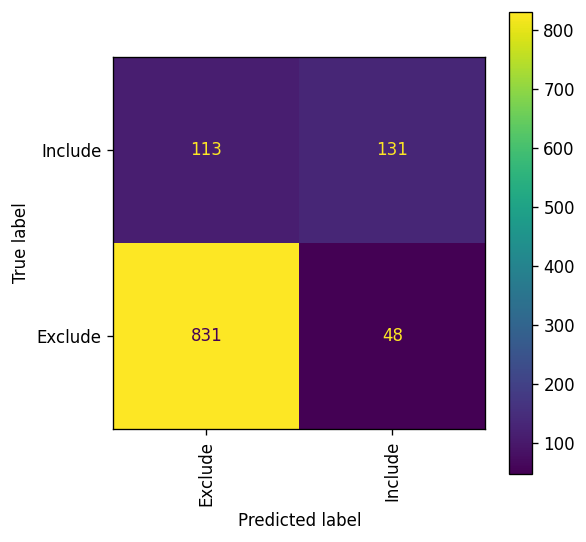

In [21]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=120)
#ax.set_title(col)
ConfusionMatrixDisplay.from_predictions(
    y_true,
    y_pred.argmax(axis=1),
    labels=list(range(len(lnames))),
    display_labels=lnames,
    xticks_rotation='vertical',
    ax=ax
)
ax.invert_yaxis()
fig.show()

/home/rept/.venvs/main12/lib/python3.12/site-packages/sklearn/metrics/_plot/roc_curve.py:171: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


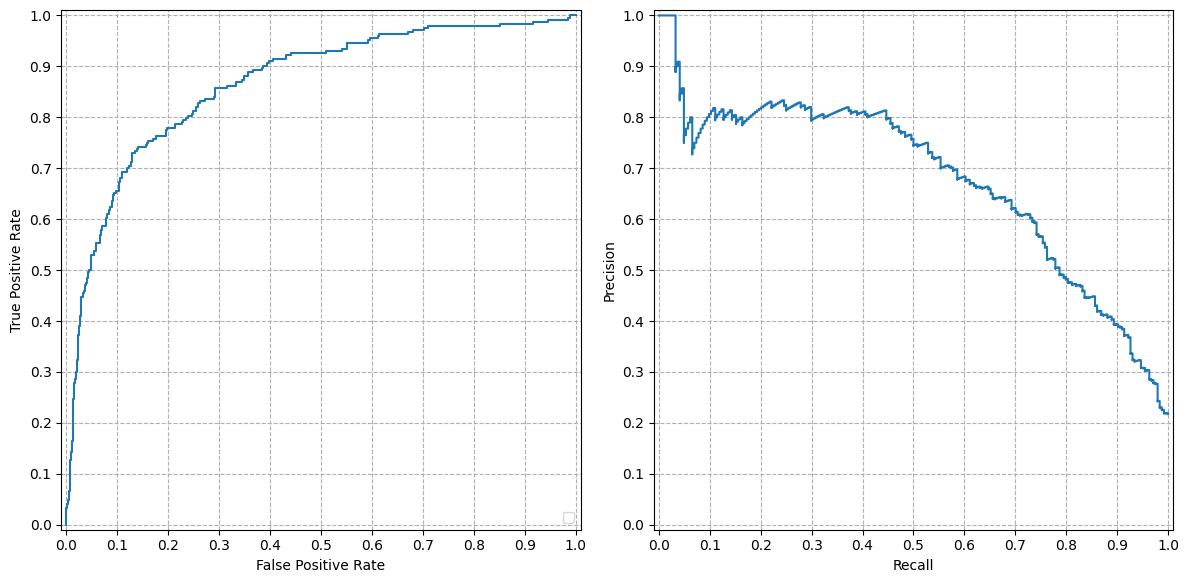

In [22]:
from matplotlib import pyplot as plt
from sklearn.metrics import RocCurveDisplay, roc_curve, precision_recall_curve, PrecisionRecallDisplay

y_true = df[df['test']==1]['inclusion'].to_numpy().astype(int)
y_scores = df[df['test']==1]['pred_incl|1'].to_numpy()

fpr, tpr, _ = roc_curve(y_true, y_scores)
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
pr_display = PrecisionRecallDisplay(precision=precision, recall=recall)

roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)
ax1.set_xticks(np.arange(0, 1.1, 0.1))
ax1.set_yticks(np.arange(0, 1.1, 0.1))
ax1.grid(visible=True, linestyle='--')
ax2.set_xticks(np.arange(0, 1.1, 0.1))
ax2.set_yticks(np.arange(0, 1.1, 0.1))
ax2.grid(visible=True, linestyle='--')
fig.tight_layout()
plt.show()

(0.0, 1.0)

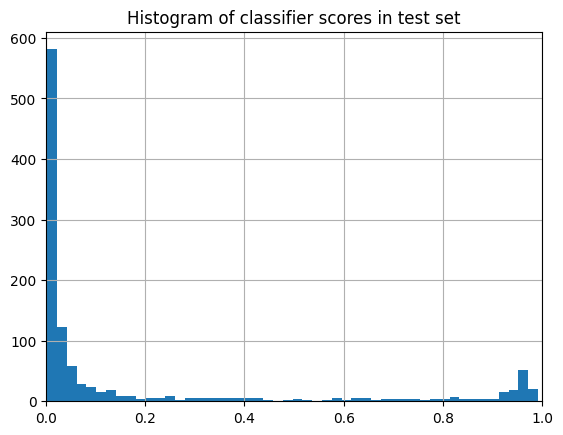

In [23]:
ax = df[df['test']==1]['pred_incl|1'].hist(bins=50)
ax.set_title('Histogram of classifier scores in test set')
ax.set_xlim(0, 1)

## Workload estimation
We'd like to know how much we ne need to annotate. Here, we compute rough estimations based on results from the latest classifier.

In [24]:
pd.DataFrame({'precision': precision, 'recall': recall, 'threshold': thresholds.tolist()+[1]}).T

0         1         2         3         4         5     \
precision  0.217275  0.217469  0.217663  0.217857  0.218052  0.218247   
recall     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
threshold  0.002281  0.002489  0.002852  0.002981  0.003027  0.003209   

               6         7         8         9         10        11    \
precision  0.218442  0.218638  0.218834  0.219031  0.218329  0.218525   
recall     1.000000  1.000000  1.000000  1.000000  0.995902  0.995902   
threshold  0.003242  0.003273  0.003275  0.003309  0.003333  0.003387   

               12        13        14        15        16        17    \
precision  0.218722  0.218919  0.219116  0.218412  0.218609  0.218807   
recall     0.995902  0.995902  0.995902  0.991803  0.991803  0.991803   
threshold  0.003388  0.003484  0.003606  0.003695  0.003696  0.003785   

               18        19        20        21        22        23    \
precision  0.219005  0.219203  0.219402  0.219601  0.219800  0.220000   
recall     0.991803  0.991803  0.991803  0.991803  0.991803  0.991803   
threshold  0.003808  0.003877  0.003890  0.003913  0.003967  0.004118   

               24        25        26        27        28        29    \
precision  0.220200  0.220401  0.220602  0.220803  0.221005  0.221207   
recall     0.991803  0.991803  0.991803  0.991803  0.991803  0.991803   
threshold  0.004180  0.004181  0.004188  0.004247  0.004280  0.004280   

               30        31        32        33        34        35    \
precision  0.221409  0.221612  0.221815  0.222018  0.222222  0.222426   
recall     0.991803  0.991803  0.991803  0.991803  0.991803  0.991803   
threshold  0.004281  0.004288  0.004305  0.004311  0.004339  0.004358   

               36        37        38        39        40        41    \
precision  0.222631  0.222836  0.223041  0.223247  0.223453  0.223660   
recall     0.991803  0.991803  0.991803  0.991803  0.991803  0.991803   
threshold  0.004372  0.004394  0.004397  0.004439  0.004457  0.004472   

               42        43        44        45        46        47    \
precision  0.223867  0.224074  0.224282  0.224490  0.224698  0.224907   
recall     0.991803  0.991803  0.991803  0.991803  0.991803  0.991803   
threshold  0.004474  0.004490  0.004526  0.004553  0.004560  0.004576   

               48        49        50        51        52        53    \
precision  0.225116  0.225326  0.225536  0.224813  0.225023  0.225234   
recall     0.991803  0.991803  0.991803  0.987705  0.987705  0.987705   
threshold  0.004603  0.004629  0.004655  0.004668  0.004670  0.004708   

               54        55        56        57        58        59    \
precision  0.225444  0.225655  0.225867  0.226079  0.226291  0.226504   
recall     0.987705  0.987705  0.987705  0.987705  0.987705  0.987705   
threshold  0.004740  0.004751  0.004781  0.004783  0.004785  0.004785   

               60        61        62        63        64        65    \
precision  0.226717  0.226930  0.227144  0.227358  0.227573  0.227788   
recall     0.987705  0.987705  0.987705  0.987705  0.987705  0.987705   
threshold  0.004788  0.004811  0.004829  0.004880  0.004895  0.004907   

               66        67        68        69        70        71    \
precision  0.228004  0.228220  0.228436  0.228653  0.228870  0.229087   
recall     0.987705  0.987705  0.987705  0.987705  0.987705  0.987705   
threshold  0.004910  0.004949  0.004962  0.004987  0.005005  0.005009   

               72        73        74        75        76        77    \
precision  0.229305  0.229524  0.229743  0.229962  0.230181  0.230402   
recall     0.987705  0.987705  0.987705  0.987705  0.987705  0.987705   
threshold  0.005015  0.005035  0.005050  0.005060  0.005068  0.005107   

               78        79        80        81        82        83    \
precision  0.229665  0.229885  0.230105  0.230326  0.230548  0.230769   
recall     0.983607  0.983607  0.983607  0.983607  0.983607 

In [25]:
for TARGET_RECALL in [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.98]:
    print('=================================')
    print(f'Stats for target recall of {TARGET_RECALL}')
    print('=================================')
    print('> Stats on test set')
    idx = np.argwhere(recall > TARGET_RECALL).max()
    print('idx', idx)
    print('num test items:', len(y_pred))
    print('threshold', thresholds[idx])
    print('precision', precision[idx])
    print('recall', recall[idx])
    print('num above threshold:', (y_pred >= thresholds[idx]).sum())
    print('num below threshold:', (y_pred < thresholds[idx]).sum())
    print('approx. false negative:', int(len(y_pred) * (1 - recall[idx])))
    print('approx. false positive:', int((y_pred >= thresholds[idx]).sum() * (1 - precision[idx])))
    print()
    
    print('> Extrapolation')
    
    mask_th = df['pred_incl|1'] > thresholds[idx]
    n_incl = mask_th.sum()
    r = recall[idx]
    p = precision[idx]

    print(f'Total documents: {df.shape[0]:,}')
    print(f'Num documents above threshold: {mask_th.sum():,}')
    print(f'Extrapolating false negatives based on test recall: {int(mask_th.sum() * (1-r)):,}')
    print(f'Extrapolating false positives based on test precision: {int(n_incl * (1-p)):,}')

    print()

Stats for target recall of 0.7
> Stats on test set
idx 848
num test items: 1123
threshold 0.14254728
precision 0.6218181818181818
recall 0.7008196721311475
num above threshold: 1279
num below threshold: 967
approx. false negative: 335
approx. false positive: 483

> Extrapolation
Total documents: 74,867
Num documents above threshold: 1,997
Extrapolating false negatives based on test recall: 597
Extrapolating false positives based on test precision: 755

Stats for target recall of 0.75
> Stats on test set
idx 798
num test items: 1123
threshold 0.08589703
precision 0.5661538461538461
recall 0.7540983606557377
num above threshold: 1343
num below threshold: 903
approx. false negative: 276
approx. false positive: 582

> Extrapolation
Total documents: 74,867
Num documents above threshold: 2,632
Extrapolating false negatives based on test recall: 647
Extrapolating false positives based on test precision: 1,141

Stats for target recall of 0.8
> Stats on test set
idx 717
num test items: 1123
thr

# Assignment
This section of the notebook can be run independently of the previous sections as it loads data from the file we saved before (assuming to ran the imports from the very first cell).

## Data loading
Fetching which items were previously assigned from the database and load the predictions from the file.

**Adjust** the filename!

In [2]:
df = pd.read_feather(f'data/screening_round_25.arrow')
df['inclusion'] = df['inclusion'].astype('Int8')
df['py'] = df['py'].astype('Int16')
df = df.replace({np.nan: None})

## Assignment stats
We'd like to know how much data we still have to assign. The following cell computes that per category of queries. It also estimates how much data there's still to annotate (>0.5 threshold)

In [4]:
print('Sanity checks:')
mask_assigned = df['assigned'].astype(bool)
mask_seen = df['seen'].astype(bool)
mask_resolved = df['resolved'].astype(bool)
mask_rel = df['Classified relevant'].astype(bool)

print(f'Assigned: {mask_assigned.sum():,}, not assigned: {(~mask_assigned).sum():,}')
print(f'Seen: {mask_seen.sum():,}, not seen: {(~mask_seen).sum():,}')
print(f'Resolved: {mask_resolved.sum():,}, not resolved: {(~mask_resolved).sum():,}')

dfs = df[~mask_assigned].sort_values('pred_incl|0').head(n=100)

t1h = dfs.index.isin(df.index)
t2h = dfs.index.isin(df[~mask_assigned & mask_rel].index)
t3h = dfs.index.isin(df[mask_rel].index)
print(f'All: {df.shape[0]:,} (above 0.5 threshold: {(df['pred_incl|1']>0.5).sum()}, in top 100: {t1h.sum():,})')
print(f'"Relevant": {mask_rel.sum():,} (above 0.5 threshold: {((df['pred_incl|1']>0.5) & mask_rel).sum()}, in top 100: {t3h.sum():,})')
print(f'Unassgined: {(~mask_assigned).sum():,} (above 0.5 threshold: {((df['pred_incl|1']>0.5) & ~mask_assigned).sum()}, in top 100: {t2h.sum():,})')
print(f'Unassgined "relevant": {(~mask_assigned & mask_rel).sum():,} (above 0.5 threshold: {((df['pred_incl|1']>0.5) & ~mask_assigned & mask_rel).sum()}, in top 100: {t2h.sum():,})')


Sanity checks:
Assigned: 5,813, not assigned: 69,054
Seen: 5,613, not seen: 69,254
Resolved: 2,099, not resolved: 72,768
All: 74,867 (above 0.5 threshold: 1187, in top 100: 100)
"Relevant": 9,131 (above 0.5 threshold: 772, in top 100: 14)
Unassgined: 69,054 (above 0.5 threshold: 227, in top 100: 14)
Unassgined "relevant": 4,349 (above 0.5 threshold: 34, in top 100: 14)


x=1186
x=771
x=33


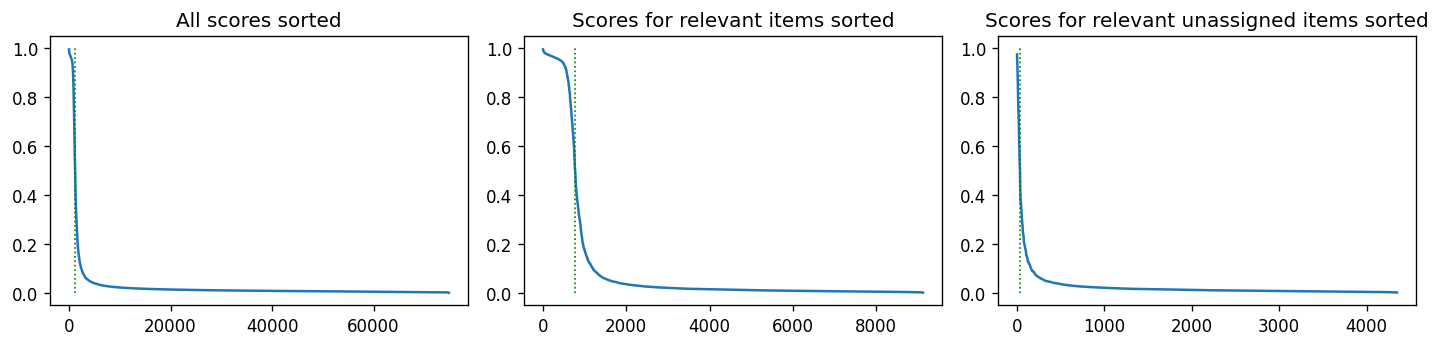

In [29]:
from matplotlib import pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,3), dpi=120)

y = np.array(sorted(df['pred_incl|1'], reverse=True))
x = np.argwhere(y > 0.5).max()
print(f'x={x}')
ax1.plot(y)
ax1.vlines(x, 0, 1, colors='green', ls=':', lw=1)
ax1.set_title('All scores sorted')

y = np.array(sorted(df[mask_rel]['pred_incl|1'], reverse=True))
x = np.argwhere(y>0.5).max()
print(f'x={x}')
ax2.plot(y)
ax2.vlines(x,0,1, colors='green', ls=':', lw=1)
ax2.set_title('Scores for relevant items sorted')

y = np.array(sorted(df[~mask_assigned & mask_rel]['pred_incl|1'], reverse=True))
x = np.argwhere(y>0.5).max()
print(f'x={x}')
ax3.plot(y)
ax3.vlines(x, 0, 1, colors='green', ls=':', lw=1)
ax3.set_title('Scores for relevant unassigned items sorted')

fig.tight_layout()

## Create assignments
Here, we finally create the assignments (and a new assignment scope). This expects that you ran everything in the *Assignment* section of this notebook up to this point. Note, that the database connection might be stale after a long training cycle, so executing this cell might hang. In this case, restart the kernel and execute all *Assignment* cells again.

Note, that there's a security switch `DRY_RUN` in this cell. This prevents you from accidentally creating assignments. You should test this cell with `True` first. When everything looks as expected, run it with `False` and change it right back again.

**Adjust** `title`, `desc`, `LIMIT`, `users`, and if needed the inner loop logic.   
The convention for the title is `[date]_[method]_[query]_[annotators]`

### Option 1) Even assignments
Everyone gets the same number of items to annotate, number of users per item adjustable

In [8]:
from nacsos_data.models.annotations import AssignmentStatus
from nacsos_data.db.schemas import AssignmentScope, Assignment

DRY_RUN = True

START = 400
LIMIT = 900
NUM_PER_ITEM = 2

users = [
    #'sarah.hoang',
    'jonas.weisser',
    'devki.natu',
    #'diana.danilenko',
    #'tarun.khanna',
    #'klaas.miersch'
]

print(f'Predicted relevant: {mask_rel.sum():,} / not assigned: {(~mask_assigned).sum():,}')

# Sort by relevance (highest inclusion first)
srtd = df[~mask_assigned].sort_values('pred_incl|0')

with db_engine.session() as session:
    title = f'027_20241111_04_prioritized_500_JW_DN'
    desc = f'Top [{START}:{LIMIT}]/{mask_rel.sum():,} documents predicted to be relevant trained on {df['seen'].sum():,} seen documents ({df['inclusion'].sum():,} included)'

    scope_id = str(uuid.uuid4())
    print(f'Creating scope "{title}" with ID {scope_id}')
    scope = AssignmentScope(
        assignment_scope_id=scope_id,
        annotation_scheme_id=SCHEME_ID,
        name=title,
        description=desc
    )
    session.add(scope)
    session.flush()

    cnt = 0
    for di, (ri, row) in enumerate(srtd[START:LIMIT].iterrows()):
        item_id = row['item_id']
        
        if not DRY_RUN:
            df.loc[ri, 'assigned'] = True

        print(f'#{di + 1}/{LIMIT-START} | Creating assignments for {item_id}')

        for ui in range(NUM_PER_ITEM):  # Number of annotators per item
            username = users[(di + ui) % len(users)]
            user_id = USERS[username]
            assi_id = uuid.uuid4()
            
            assi = Assignment(assignment_id=assi_id,
                              assignment_scope_id=scope_id,
                              user_id=user_id,
                              item_id=item_id,
                              annotation_scheme_id=SCHEME_ID,
                              status=AssignmentStatus.OPEN,
                              order=di)
            session.add(assi)
            session.flush()
            cnt += 1
            print(f'  -> {username} via {assi_id} for scope {scope_id}')
            
    if not DRY_RUN:
        session.commit()
        print(f'Created {cnt} assignments!')
    else:
        print(f'Pretended to have created {cnt} assignments!')

Predicted relevant: 9,131 / not assigned: 69,054
Creating scope "027_20241111_04_prioritized_500_JW_DN" with ID 4e8e7aac-7220-4cdd-a8b5-5bb27fabf0ff
#1/500 | Creating assignments for d147fc74-d327-4483-85a4-e9421034d970
  -> jonas.weisser via da83d507-5bb9-48ee-9cda-48f7cdf14d81 for scope 4e8e7aac-7220-4cdd-a8b5-5bb27fabf0ff
  -> devki.natu via 06367a6f-d3ce-4fe6-a9b2-19cd654934ad for scope 4e8e7aac-7220-4cdd-a8b5-5bb27fabf0ff
#2/500 | Creating assignments for 4d7d71c0-229c-425c-830b-d9f437d41b6f
  -> devki.natu via caee59fa-4392-4740-b46c-a1f16066f052 for scope 4e8e7aac-7220-4cdd-a8b5-5bb27fabf0ff
  -> jonas.weisser via f9d5ff74-d9d6-4e63-9312-eea76f58e214 for scope 4e8e7aac-7220-4cdd-a8b5-5bb27fabf0ff
#3/500 | Creating assignments for b9d141bf-55cf-41fa-b412-2685c6aa79e4
  -> jonas.weisser via 2b924efe-b2ed-4da3-8073-d63fc9f3da03 for scope 4e8e7aac-7220-4cdd-a8b5-5bb27fabf0ff
  -> devki.natu via e318b052-9fef-4365-9a37-149752a39de9 for scope 4e8e7aac-7220-4cdd-a8b5-5bb27fabf0ff
#4/50

In [ ]:
from nacsos_data.models.annotations import AssignmentStatus
from nacsos_data.db.schemas import AssignmentScope, Assignment

DRY_RUN = True

START = 300
LIMIT = START + 300
NUM_PER_ITEM = 2

users = [
    #'sarah.hoang',
    'devki.natu',
    'jonas.weisser',
    #'diana.danilenko',
    #'tarun.khanna',
    #'klaas.miersch'
]

print(f'Predicted relevant: {mask_rel.sum():,} / not assigned: {(~mask_assigned).sum():,}')

# Sort by relevance (highest inclusion first)
srtd = df[~mask_assigned].sort_values('pred_incl|0')

with db_engine.session() as session:
    title = f'021_20241010_02_prioritised_300_DN_JW'
    desc = f'Top [{START}:{LIMIT}]/{mask_rel.sum():,} documents predicted to be relevant trained on {df['seen'].sum():,} seen documents ({df['inclusion'].sum():,} included)'

    scope_id = str(uuid.uuid4())
    print(f'Creating scope "{title}" with ID {scope_id}')
    scope = AssignmentScope(
        assignment_scope_id=scope_id,
        annotation_scheme_id=SCHEME_ID,
        name=title,
        description=desc
    )
    session.add(scope)
    session.flush()

    cnt = 0
    for di, (ri, row) in enumerate(srtd[START:LIMIT].iterrows()):
        item_id = row['item_id']
        
        if not DRY_RUN:
            df.loc[ri, 'assigned'] = True

        print(f'#{di + 1}/{LIMIT-START} | Creating assignments for {item_id}')

        for ui in range(NUM_PER_ITEM):  # Number of annotators per item
            username = users[(di + ui) % len(users)]
            user_id = USERS[username]
            assi_id = uuid.uuid4()
            
            assi = Assignment(assignment_id=assi_id,
                              assignment_scope_id=scope_id,
                              user_id=user_id,
                              item_id=item_id,
                              annotation_scheme_id=SCHEME_ID,
                              status=AssignmentStatus.OPEN,
                              order=di)
            session.add(assi)
            session.flush()
            cnt += 1
            print(f'  -> {username} via {assi_id} for scope {scope_id}')
            
    if not DRY_RUN:
        session.commit()
        print(f'Created {cnt} assignments!')
    else:
        print(f'Pretended to have created {cnt} assignments!')

### Option 2) Uneven assignments
One gets all items, double coding alternating between other users.

In [ ]:
from nacsos_data.models.annotations import AssignmentStatus
from nacsos_data.db.schemas import AssignmentScope, Assignment

DRY_RUN = True

LIMIT = 400
NUM_PER_ITEM = 2

single_user = 'sarah.hoang'

users = [
    #'diana.danilenko',
    'tarun.khanna',
    'klaas.miersch'
]

# sorted relevant by relevance (highest inclusion first)
srtd = df[mask_rel & ~mask_assigned].sort_values('pred_incl|0')

def _assign(session, username, item_id):
    user_id = USERS[username]
    assi_id = uuid.uuid4()
    
    if not DRY_RUN:
        assi = Assignment(assignment_id=assi_id,
                          assignment_scope_id=scope_id,
                          user_id=user_id,
                          item_id=item_id,
                          annotation_scheme_id=SCHEME_ID,
                          status=AssignmentStatus.OPEN,
                          order=di)
        session.add(assi)
        session.flush()
    print(f'  -> {username} via {assi_id} for scope {scope_id}')
    
    return assi_id

with db_engine.session() as session:
    title = f'20240821_prioritised_SH_TK_KM'
    desc = f'Top {LIMIT} documents predicted to be relevant'

    scope_id = str(uuid.uuid4())
    print(f'Creating scope "{title}" with ID {scope_id}')
    if not DRY_RUN:
        scope = AssignmentScope(
            assignment_scope_id=scope_id,
            annotation_scheme_id=SCHEME_ID,
            name=title,
            description=desc
        )
        session.add(scope)
        session.flush()

    cnt = 0
    for di, (ri, row) in enumerate(srtd.head(LIMIT).iterrows()):
        item_id = row['item_id']
        
        if not DRY_RUN:
            df.loc[ri, 'assigned'] = True

        print(f'#{di + 1}/{LIMIT} | Creating assignments for {item_id}')

        _assign(session, single_user, item_id)
        cnt += 1

        for ui in range(NUM_PER_ITEM - 1):  # Number of annotators per item
            username = users[(di + ui) % len(users)]
            _assign(session, username, item_id)
            cnt += 1

    print(f'Created {cnt} assignments!')

### Option 3) Weirdly uneven assignments
One gets all items, the others get the same subset of other items.

In [ ]:
from nacsos_data.models.annotations import AssignmentStatus
from nacsos_data.db.schemas import AssignmentScope, Assignment

DRY_RUN = True

LIMIT = 400
single_user = 'sarah.hoang'
users = [
    #'diana.danilenko',
    #'tarun.khanna',
    #'klaas.miersch'
    'devki.natu',
    'jonas.weisser'
]

# sorted relevant by relevance (highest inclusion first)
srtd = df[mask_rel & ~mask_assigned].sort_values('pred_incl|0')

def _assign(session, username, item_id):
    user_id = USERS[username]
    assi_id = uuid.uuid4()
    
    if not DRY_RUN:
        assi = Assignment(assignment_id=assi_id,
                          assignment_scope_id=scope_id,
                          user_id=user_id,
                          item_id=item_id,
                          annotation_scheme_id=SCHEME_ID,
                          status=AssignmentStatus.OPEN,
                          order=di)
        session.add(assi)
        session.flush()
    print(f'  -> {username} via {assi_id} for scope {scope_id}')
    
    return assi_id

with db_engine.session() as session:
    title = f'20240905_01_prioritised_SH_DN_JW'
    desc = f'Top {LIMIT} documents predicted to be relevant'

    scope_id = str(uuid.uuid4())
    print(f'Creating scope "{title}" with ID {scope_id}')
    if not DRY_RUN:
        scope = AssignmentScope(
            assignment_scope_id=scope_id,
            annotation_scheme_id=SCHEME_ID,
            name=title,
            description=desc
        )
        session.add(scope)
        session.flush()

    cnt = 0
    for di, (ri, row) in enumerate(srtd.head(LIMIT).iterrows()):
        item_id = row['item_id']
        
        if not DRY_RUN:
            df.loc[ri, 'assigned'] = True

        print(f'#{di + 1}/{LIMIT} | Creating assignments for {item_id}')

        _assign(session, single_user, item_id)
        cnt += 1

        if (di % 4) == 0:
            for username in users:
                _assign(session, username, item_id)
                cnt += 1

    print(f'Created {cnt} assignments!')

SECOND_LIMIT = 50
users = [
    #'diana.danilenko',
    #'tarun.khanna',
    #'klaas.miersch'
    'sarah.hoang',
    'devki.natu',
    'jonas.weisser'
]
with db_engine.session() as session:
    title = f'20240905_02_prioritised_SH_DN_JW'
    desc = f'Top {LIMIT} + {SECOND_LIMIT} documents predicted to be relevant'

    scope_id = str(uuid.uuid4())
    print(f'Creating scope "{title}" with ID {scope_id}')
    if not DRY_RUN:
        scope = AssignmentScope(
            assignment_scope_id=scope_id,
            annotation_scheme_id=SCHEME_ID,
            name=title,
            description=desc
        )
        session.add(scope)
        session.flush()

    cnt = 0
    for di, (ri, row) in enumerate(srtd[LIMIT:LIMIT + SECOND_LIMIT].iterrows()):
        item_id = row['item_id']
        
        if not DRY_RUN:
            df.loc[ri, 'assigned'] = True

        print(f'#{di + 1}/{SECOND_LIMIT} | Creating assignments for {item_id}')

        for username in users:
            _assign(session, username, item_id)
            cnt += 1

    print(f'Created {cnt} assignments!')


THIRD_LIMIT = 25
users = [
    #'diana.danilenko',
    #'tarun.khanna',
    'klaas.miersch',
    'sarah.hoang',
    'devki.natu',
    'jonas.weisser',
]
with db_engine.session() as session:
    title = f'20240905_03_prioritised_SH_DN_JW'
    desc = f'Top {LIMIT} + {SECOND_LIMIT} + {THIRD_LIMIT} documents predicted to be relevant'

    scope_id = str(uuid.uuid4())
    print(f'Creating scope "{title}" with ID {scope_id}')
    if not DRY_RUN:
        scope = AssignmentScope(
            assignment_scope_id=scope_id,
            annotation_scheme_id=SCHEME_ID,
            name=title,
            description=desc
        )
        session.add(scope)
        session.flush()

    cnt = 0
    for di, (ri, row) in enumerate(srtd[LIMIT + SECOND_LIMIT:LIMIT + SECOND_LIMIT + THIRD_LIMIT].iterrows()):
        item_id = row['item_id']
        
        if not DRY_RUN:
            df.loc[ri, 'assigned'] = True

        print(f'#{di + 1}/{THIRD_LIMIT} | Creating assignments for {item_id}')

        for username in users:
            _assign(session, username, item_id)
            cnt += 1

    print(f'Created {cnt} assignments!')

# Storing assignments
We'd like to keep the assignments outside of the platform if we need it again. 

**Adjust** the filename by increasing the counter by 1.

In [ ]:
df.to_feather(f'data/screening_round_20_post.arrow')